In [69]:
import numpy as np
from scipy.stats import norm, laplace, cauchy, multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import autograd as ad
from autograd.variable import Variable

np.random.seed(8)

### Utility Functions


In [70]:
def traceplot(samples, w=6, h=4, overlay=True, n_col=2):
    # samples: [#components, #iterations]
    
    n_component = samples.shape[0]
    n_iter = samples.shape[1]

    if overlay:
        fig, ax = plt.subplots(figsize=(6,4))
        
        for i in range(n_component):
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], label=rf'$X_{i+1}$', linewidth=0.5, legend=False)

        # Set labels
        ax.set_xlabel('t')
        ax.set_ylabel(r'$X_i(t)$')

        # Create figure-level legend outside the plot
        fig.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), frameon=False)

        # Modify the line width in the legend
        legend = fig.legends[0]
        for line in legend.get_lines():
            line.set_linewidth(1)
        
        plt.show()
    else:
        n_row = np.ceil(n_component / n_col).astype(int)

        fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(w*n_col, h*n_row))

        for i in range(n_component):
            ax = axes.flat[i]
            
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], ax=ax, linewidth=0.5)
            
            # Set labels
            ax.set_xlabel('t')
            ax.set_ylabel(r'$X_i(t)$')

        # Delete any unused axes (if there are fewer features than subplot slots)
        for i in range(n_component, len(axes.flat)):
            fig.delaxes(axes.flat[i])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()                     

### Log Distributions


In [71]:
def logpi_normal(x, location=0, scale=1):
    return np.sum(norm.logpdf(x, loc=location, scale=scale))

def logpi_laplace(x, location=0, scale=1):
    return np.sum(laplace.logpdf(x, loc=location, scale=scale))

def logpi_cauchy(x, location=0, scale=1):
    return np.sum(cauchy.logpdf(x, loc=location, scale=scale))

def logpi_mvnormal(x, location=[0], covariance=[1]):
    return np.sum(multivariate_normal, mean=location, cov=covariance)

In [72]:
def partial_logpi_normal(x, location=0, scale=1):
    x = np.array(x)
    return - (1/2) * np.log(2 * np.pi * scale**2)  - (1/2) * ((x - location) / scale)**2

### MCMC Algorithms


In [81]:
def RWM(logpi, n_iter, step_size, x_current, *args):
    # x_current: [#components]
    
    # Number of dimensions
    d = len(x_current)

    # Log of the target distribution at the current state
    logpi_current = logpi(x_current, *args)

    # Counter for accepted proposals
    accepted = 0

    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((d, n_iter))

    for i in range(n_iter):
        # Propose a candidate move
        x_proposal = x_current + step_size * np.random.normal(size=d)
        logpi_proposal = logpi(x_proposal, *args)

        # Calculate the difference in the log-probabilities of the proposed and
        # current states (i.e. \log \frac{\pi(y)}{\pi(x)})
        log_acceptance = logpi_proposal - logpi_current

        u = np.random.uniform(size=1)

        # Acceptance criterion
        if np.log(u) < log_acceptance:
            # If accepted, update the current state and log-probability
            x_current = x_proposal
            logpi_current = logpi_proposal
            accepted +=1

        # Store the current state
        x_samples[:, i] = x_current

    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

In [85]:
# Let q be Normal

def BarkerMH(logpi, partial_logpi, n_iter, x, *args):
    # Number of dimensions
    d = len(x)

    # Log of the target distribution at the current state
    logpi_x = logpi(x, *args)

    # Counter for accepted proposals
    accepted = 0

    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((d, n_iter))

    for i in range(n_iter):
        z = np.random.normal(size=d)

        beta_x = partial_logpi(x, *args)

        threshold = 1 / (1 + np.exp(-beta_x * z))
        b = np.where(np.random.uniform(size=1) < threshold, 1, -1) # size(?)

        y = x + b * z
        logpi_y = logpi(y, *args)

        beta_y = partial_logpi(y, *args)

        log_acceptance = logpi_y - logpi_x + np.sum(np.log(1 + np.exp((x - y) * beta_x)) - np.log(1 + np.exp((y - x) * beta_y)))

        u = np.random.uniform(size=1)

        # Acceptance criterion
        if np.log(u) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store the current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

### Experiments


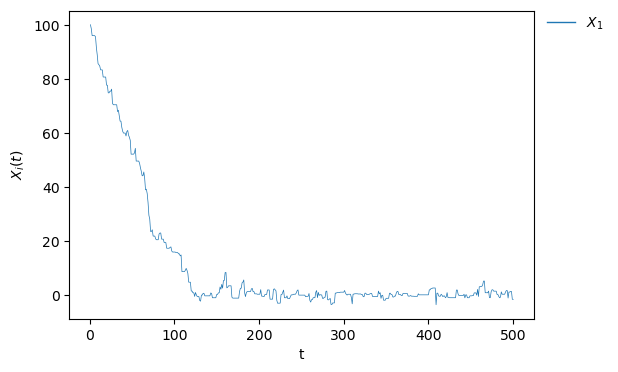

In [86]:
samples, accept_rate = RWM(logpi=logpi_laplace, n_iter=500, step_size=2.5, x_current=np.array([100]))

traceplot(samples)

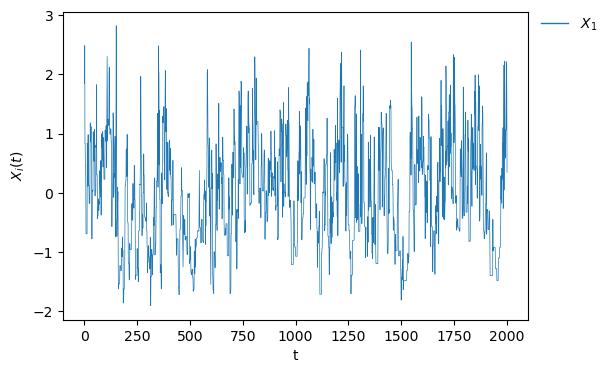

0.5515


In [128]:
samples, accept_rate = BarkerMH(logpi=logpi_normal, partial_logpi=partial_logpi_normal, n_iter=2000, x=np.array([0]))

traceplot(samples)

print(accept_rate)